In [17]:
!pip install -U scikit-learn scipy matplotlib

     ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
      --------------------------------------- 0.1/9.2 MB 4.2 MB/s eta 0:00:03
     - -------------------------------------- 0.4/9.2 MB 4.6 MB/s eta 0:00:02
     -- ------------------------------------- 0.6/9.2 MB 5.0 MB/s eta 0:00:02
     ----- ---------------------------------- 1.2/9.2 MB 7.1 MB/s eta 0:00:02
     ------- -------------------------------- 1.8/9.2 MB 8.2 MB/s eta 0:00:01
     ---------- ----------------------------- 2.4/9.2 MB 9.5 MB/s eta 0:00:01
     ------------- -------------------------- 3.2/9.2 MB 10.2 MB/s eta 0:00:01
     -------------- ------------------------- 3.3/9.2 MB 9.6 MB/s eta 0:00:01
     ---------------- ----------------------- 3.8/9.2 MB 9.8 MB/s eta 0:00:01
     ------------------- -------------------- 4.4/9.2 MB 10.1 MB/s eta 0:00:01
     ---------------------- ----------------- 5.2/9.2 MB 11.0 MB/s eta 0:00:01
     ----------------------- ---------------- 5.4/9.2 MB 10.9 MB/s e


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\gSegoun\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:
# Import all necessary libraries

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from math import radians, cos, sin, asin, sqrt
from pandas.tseries.holiday import USFederalHolidayCalendar

import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

In [21]:
# Read the train and test datasets
train_data = pd.read_csv('./data/split_train.csv', delimiter=";")
test_data = pd.read_csv('./data/split_test.csv', delimiter=";")

# INITIAL DATA PRE-PROCESSING 

In [22]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1603037,1,25/06/2016 10:36,25/06/2016 10:55,1,-73.993553,40.747173,-74.006142,40.704384,N,1163
1,id2403238,1,23/06/2016 23:00,23/06/2016 23:04,1,-73.988068,40.728081,-73.980751,40.721470,N,277
2,id3913101,1,25/06/2016 22:05,25/06/2016 22:22,2,-74.001411,40.761433,-73.924629,40.864029,N,1003
3,id1297351,2,24/06/2016 14:24,24/06/2016 14:32,1,-74.003288,40.726971,-73.993301,40.739120,N,470
4,id2146569,2,23/06/2016 22:17,23/06/2016 22:21,1,-73.976799,40.749950,-73.981567,40.745770,N,212


In [23]:
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,25489.000000,25489.000000,25489.000000,25489.000000,25489.000000,25489.000000,25489.000000
mean,1.533210,1.673938,-73.973884,40.750020,-73.973705,40.751338,1033.221390
std,0.498906,1.309718,0.038685,0.028541,0.037190,0.033034,3493.110293
min,1.000000,1.000000,-74.178223,40.213837,-74.301483,40.298828,1.000000
25%,1.000000,1.000000,-73.992500,40.736420,-73.991730,40.735001,419.000000
50%,2.000000,1.000000,-73.982132,40.752785,-73.980240,40.753933,698.000000
75%,2.000000,2.000000,-73.968124,40.766945,-73.963356,40.769203,1133.000000
max,2.000000,9.000000,-73.384659,40.924129,-73.193268,41.111416,86340.000000


In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25489 entries, 0 to 25488
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  25489 non-null  object 
 1   vendor_id           25489 non-null  int64  
 2   pickup_datetime     25489 non-null  object 
 3   dropoff_datetime    25489 non-null  object 
 4   passenger_count     25489 non-null  int64  
 5   pickup_longitude    25489 non-null  float64
 6   pickup_latitude     25489 non-null  float64
 7   dropoff_longitude   25489 non-null  float64
 8   dropoff_latitude    25489 non-null  float64
 9   store_and_fwd_flag  25489 non-null  object 
 10  trip_duration       25489 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 2.1+ MB


In [25]:
train_data[train_data.isna().any(axis=1)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [29]:
train_data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [37]:
# remove outliers for passenger_count 7,8,9,0
# pas de passage_count = 0,7,8 
# 1 ligne pour passage_count = 9
index = train_data[ (train_data['passenger_count'] == 7) | (train_data['passenger_count'] == 8) | (train_data['passenger_count'] == 9) | (train_data['passenger_count'] == 0)].index
train_data.drop(index , inplace=True)

In [41]:
mean = np.mean(train_data['trip_duration'])
print("Mean for Trip Duration is:", mean)

standard_deviation = np.std(train_data['trip_duration'])
print("Standard Deviation for Trip Duration is:", standard_deviation)

# supprimer les valeurs abérrantes éloignées de 2 ecrats type  de la moyenne

train_data = train_data[train_data['trip_duration'].between(mean - 2*standard_deviation, mean + 2*standard_deviation)]
train_data.describe()


Mean for Trip Duration is: 1033.2399560577526
Standard Deviation for Trip Duration is: 3493.109034977696


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,25436.000000,25436.000000,25436.000000,25436.000000,25436.000000,25436.000000,25436.000000
mean,1.532277,1.672983,-73.973912,40.750048,-73.973719,40.751346,890.238363
std,0.498967,1.308361,0.038589,0.028511,0.037145,0.033033,719.895132
min,1.000000,1.000000,-74.178223,40.213837,-74.301483,40.298828,1.000000
25%,1.000000,1.000000,-73.992510,40.736448,-73.991730,40.735006,419.000000
50%,2.000000,1.000000,-73.982132,40.752800,-73.980232,40.753954,697.000000
75%,2.000000,2.000000,-73.968122,40.766961,-73.963354,40.769211,1130.000000
max,2.000000,6.000000,-73.384659,40.924129,-73.193268,41.111416,6900.000000


In [42]:
# Data Formatting

train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map(lambda x: 0 if x == 'N' else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].map(lambda x: 0 if x == 'N' else 1)

In [49]:
# Feature Extraction
# Decomposing timestamp for train data into date and time

train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pickup_date'] = train_data['pickup_datetime'].dt.date
train_data.loc[:, 'pickup_time'] = train_data['pickup_datetime'].dt.time
train_data['dropoff_datetime'] = pd.to_datetime(train_data.dropoff_datetime)
train_data.loc[:, 'dropoff_date'] = train_data['dropoff_datetime'].dt.date
train_data.loc[:, 'dropoff_time'] = train_data['dropoff_datetime'].dt.time
train_data.loc[:, 'dropoff_hour'] = train_data['dropoff_datetime'].dt.hour
train_data.loc[:, 'dropoff_weekday'] = train_data['dropoff_datetime'].dt.weekday
train_data.loc[:, 'dropoff_month'] = train_data['dropoff_datetime'].dt.month
train_data.loc[:, 'pickup_weekday'] = train_data['pickup_datetime'].dt.weekday
train_data.loc[:, 'pickup_weekofyear'] = train_data['pickup_datetime'].dt.isocalendar().week
train_data.loc[:, 'pickup_hour'] = train_data['pickup_datetime'].dt.hour
train_data.loc[:, 'pickup_minute'] = train_data['pickup_datetime'].dt.minute
train_data.loc[:, 'pickup_dt'] = (train_data['pickup_datetime'] - train_data['pickup_datetime'].min()).dt.total_seconds()
train_data.loc[:, 'pickup_week_hour'] = train_data['pickup_weekday'] * 24 + train_data['pickup_hour']
train_data.loc[:, 'pickup_dayofyear'] = train_data['pickup_datetime'].dt.dayofyear
train_data.loc[:, 'pickup_month'] = train_data['pickup_datetime'].dt.month

train_data


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_weekday,dropoff_month,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,pickup_dayofyear,pickup_month
0,id1603037,1,2016-06-25 10:36:00,2016-06-25 10:55:00,1,-73.993553,40.747173,-74.006142,40.704384,0,...,5,6,5,25,10,36,297360.0,130,177,6
1,id2403238,1,2016-06-23 23:00:00,2016-06-23 23:04:00,1,-73.988068,40.728081,-73.980751,40.721470,0,...,3,6,3,25,23,0,169200.0,95,175,6
2,id3913101,1,2016-06-25 22:05:00,2016-06-25 22:22:00,2,-74.001411,40.761433,-73.924629,40.864029,0,...,5,6,5,25,22,5,338700.0,142,177,6
3,id1297351,2,2016-06-24 14:24:00,2016-06-24 14:32:00,1,-74.003288,40.726971,-73.993301,40.739120,0,...,4,6,4,25,14,24,224640.0,110,176,6
4,id2146569,2,2016-06-23 22:17:00,2016-06-23 22:21:00,1,-73.976799,40.749950,-73.981567,40.745770,0,...,3,6,3,25,22,17,166620.0,94,175,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25484,id2531113,2,2016-06-24 19:46:00,2016-06-24 20:02:00,1,-73.971252,40.795361,-73.938461,40.811871,0,...,4,6,4,25,19,46,243960.0,115,176,6
25485,id0709349,2,2016-06-22 07:40:00,2016-06-22 07:48:00,2,-73.954704,40.765621,-73.981911,40.740059,0,...,2,6,2,25,7,40,27600.0,55,174,6
25486,id1325903,2,2016-06-22 08:15:00,2016-06-22 08:33:00,1,-73.991096,40.733040,-74.009102,40.715580,0,...,2,6,2,25,8,15,29700.0,56,174,6
25487,id1545454,2,2016-06-25 01:19:00,2016-06-25 01:28:00,1,-73.988930,40.730770,-73.978088,40.752869,0,...,5,6,5,25,1,19,263940.0,121,177,6


In [51]:
# Feature Extraction
# Decomposing timestamp for test data into date and time

test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data.loc[:, 'pickup_date'] = test_data['pickup_datetime'].dt.date
test_data.loc[:, 'pickup_time'] = test_data['pickup_datetime'].dt.time
test_data.loc[:, 'pickup_weekday'] = test_data['pickup_datetime'].dt.weekday
test_data.loc[:, 'pickup_weekofyear'] = test_data['pickup_datetime'].dt.isocalendar().week
test_data.loc[:, 'pickup_hour'] = test_data['pickup_datetime'].dt.hour
test_data.loc[:, 'pickup_minute'] = test_data['pickup_datetime'].dt.minute
test_data.loc[:, 'pickup_dt'] = (test_data['pickup_datetime'] - test_data['pickup_datetime'].min()).dt.total_seconds()
test_data.loc[:, 'pickup_week_hour'] = test_data['pickup_weekday'] * 24 + test_data['pickup_hour']
test_data.loc[:, 'pickup_dayofyear'] = test_data['pickup_datetime'].dt.dayofyear
test_data.loc[:, 'pickup_month'] = test_data['pickup_datetime'].dt.month

test_data

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,pickup_time,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,pickup_dayofyear,pickup_month
0,id2611124,2,2016-06-25 23:59:00,1,-73.997139,40.762432,-73.979774,40.714630,0,2016-06-25,23:59:00,5,25,23,59,345540.0,143,177,6
1,id0356465,1,2016-06-25 23:59:00,1,-73.989281,40.718884,-73.884087,40.748047,0,2016-06-25,23:59:00,5,25,23,59,345540.0,143,177,6
2,id0037416,1,2016-06-25 23:59:00,1,-74.014664,40.707886,-73.992447,40.723995,0,2016-06-25,23:59:00,5,25,23,59,345540.0,143,177,6
3,id0888730,1,2016-06-25 23:58:00,1,-73.978584,40.745728,-73.989685,40.715607,0,2016-06-25,23:58:00,5,25,23,58,345480.0,143,177,6
4,id3006051,2,2016-06-25 23:58:00,5,-73.975647,40.740170,-73.987427,40.744068,0,2016-06-25,23:58:00,5,25,23,58,345480.0,143,177,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13941,id3585380,1,2016-06-22 00:02:00,1,-73.993538,40.752022,-73.990105,40.725246,0,2016-06-22,00:02:00,2,25,0,2,120.0,48,174,6
13942,id0793775,2,2016-06-22 00:00:00,1,-73.870903,40.773762,-73.760559,41.029789,0,2016-06-22,00:00:00,2,25,0,0,0.0,48,174,6
13943,id1229332,2,2016-06-22 00:00:00,1,-73.987511,40.765491,-74.007309,40.705101,0,2016-06-22,00:00:00,2,25,0,0,0.0,48,174,6
13944,id1811308,2,2016-06-22 00:00:00,1,-74.004204,40.742218,-73.985703,40.751865,0,2016-06-22,00:00:00,2,25,0,0,0.0,48,174,6


In [58]:
# Feature Extraction


#

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

# crées une variable qui détermine si le pickup_date est un jour férié
train_data['pickup_holiday'] = pd.to_datetime(train_data.pickup_datetime.dt.date).isin(holidays)
train_data['pickup_holiday'] = train_data.pickup_holiday.map(lambda x: 1 if x == True else 0)

# crées une variable détermine si  le pickup_date est la veille ou le lendemain des joutrs fériés. Si oui, la variable est égale à 0
train_data['pickup_near_holiday'] = (pd.to_datetime(train_data.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(train_data.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
train_data['pickup_near_holiday'] = train_data.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

train_data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,pickup_dayofyear,pickup_month,pickup_holiday,pickup_near_holiday
0,id1603037,1,2016-06-25 10:36:00,2016-06-25 10:55:00,1,-73.993553,40.747173,-74.006142,40.704384,0,...,5,25,10,36,297360.0,130,177,6,0,0
1,id2403238,1,2016-06-23 23:00:00,2016-06-23 23:04:00,1,-73.988068,40.728081,-73.980751,40.721470,0,...,3,25,23,0,169200.0,95,175,6,0,0
2,id3913101,1,2016-06-25 22:05:00,2016-06-25 22:22:00,2,-74.001411,40.761433,-73.924629,40.864029,0,...,5,25,22,5,338700.0,142,177,6,0,0
3,id1297351,2,2016-06-24 14:24:00,2016-06-24 14:32:00,1,-74.003288,40.726971,-73.993301,40.739120,0,...,4,25,14,24,224640.0,110,176,6,0,0
4,id2146569,2,2016-06-23 22:17:00,2016-06-23 22:21:00,1,-73.976799,40.749950,-73.981567,40.745770,0,...,3,25,22,17,166620.0,94,175,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25484,id2531113,2,2016-06-24 19:46:00,2016-06-24 20:02:00,1,-73.971252,40.795361,-73.938461,40.811871,0,...,4,25,19,46,243960.0,115,176,6,0,0
25485,id0709349,2,2016-06-22 07:40:00,2016-06-22 07:48:00,2,-73.954704,40.765621,-73.981911,40.740059,0,...,2,25,7,40,27600.0,55,174,6,0,0
25486,id1325903,2,2016-06-22 08:15:00,2016-06-22 08:33:00,1,-73.991096,40.733040,-74.009102,40.715580,0,...,2,25,8,15,29700.0,56,174,6,0,0
25487,id1545454,2,2016-06-25 01:19:00,2016-06-25 01:28:00,1,-73.988930,40.730770,-73.978088,40.752869,0,...,5,25,1,19,263940.0,121,177,6,0,0


In [57]:
# Identifying holidays for test data from USFederalHolidayCalendar()

test_data['pickup_holiday'] = pd.to_datetime(test_data.pickup_datetime.dt.date).isin(holidays)
test_data['pickup_holiday'] = test_data.pickup_holiday.map(lambda x: 1 if x == True else 0)
test_data['pickup_near_holiday'] = (pd.to_datetime(test_data.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(test_data.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
test_data['pickup_near_holiday'] = test_data.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

### COMPUTE DISTANCES (Using Longitudes & Latitudes)

In order of increasing importance/accuracy:
(Haversine Distance = Bearing Distance) < Manhattan Distance < OSRM Dataset Distance < Google Distance API

In [56]:
# Compute Distances using Longitudes & Latitudes 

# 1 Haversine Distance
def haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# 2 Bearing Distance 
def bearing_direction(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# 3 Manhattan Distance
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_distance(lat1, lng1, lat1, lng2)
    b = haversine_distance(lat1, lng1, lat2, lng1)
    return a + b


In [60]:
train_data.loc[:, 'direction'] = bearing_direction(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:, 'distance_haversine'] = haversine_distance(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:, 'distance_manhattan'] = manhattan_distance(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:, 'center_latitude'] = (train_data['pickup_latitude'].values + train_data['dropoff_latitude'].values) / 2
train_data.loc[:, 'center_longitude'] = (train_data['pickup_longitude'].values + train_data['dropoff_longitude'].values) / 2

In [61]:
test_data.loc[:, 'direction'] = bearing_direction(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_haversine'] = haversine_distance(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_manhattan'] = manhattan_distance(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:, 'center_latitude'] = (test_data['pickup_latitude'].values + test_data['dropoff_latitude'].values) / 2
test_data.loc[:, 'center_longitude'] = (test_data['pickup_longitude'].values + test_data['dropoff_longitude'].values) / 2

In [59]:
google_distance_dataset = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/pizzarush-40b2f.appspot.com/o/train_with_distance848k.csv?alt=media&token=48501761-2b33-4508-9589-4ceb2eabe33d')
google_distance_dataset.head()

,Unnamed: 0,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,dropoff_day,dropoff_hour,dropoff_dayofweek,duration_time,distance_m,distance_km,pickup_date_isHoliday,dropoff_date_isHoliday,pickup_combined,google_distance
0,0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,14,17,0,< 5,1502.171837,1.502172,False,False,23464.246452,2005.0
1,1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,12,0,6,< 5,1808.659969,1.808660,False,False,23458.961021,2515.0
2,2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,19,12,1,5-10,6379.687175,6.379687,False,False,23463.529976,9916.0
3,3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,6,19,2,< 5,1483.632481,1.483632,False,False,23455.584686,1779.0
4,4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,26,13,5,< 5,1187.037659,1.187038,False,False,23468.804581,1607.0


**Google Distance API**

The distance between each longitude and latitude of every record is calculated here using the Google Maps Distance Matrix API.
The code has been commented here to avoid running the code snippet again due to request restrictions of the *free tier API Key*, after scraping the distance for all of the 1.5 million datapoints.

In [69]:
google_distance = google_distance_dataset[:50]['google_distance']
print(google_distance)

0      2005.0
1      2515.0
2      9916.0
3      1779.0
4      1607.0
5      1394.0
6      1701.0
7     11656.0
8      1645.0
9      6714.0
10     4463.0
11     5603.0
12     2279.0
13     1341.0
14     7950.0
15      898.0
16     4710.0
17     3307.0
18     4664.0
19     1333.0
20     7692.0
21     2708.0
22     3444.0
23     6831.0
24    30096.0
25     5413.0
26     7311.0
27     4258.0
28     2526.0
29    16372.0
30     4928.0
31     9038.0
32     8304.0
33    16316.0
34     1728.0
35     2312.0
36     2307.0
37     1236.0
38     4375.0
39     3854.0
40     6572.0
41     2977.0
42     2784.0
43     2021.0
44     2429.0
45     9061.0
46     1525.0
47     1910.0
48     5494.0
49     4820.0
Name: google_distance, dtype: float64


In [72]:
x = list(range(20))
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

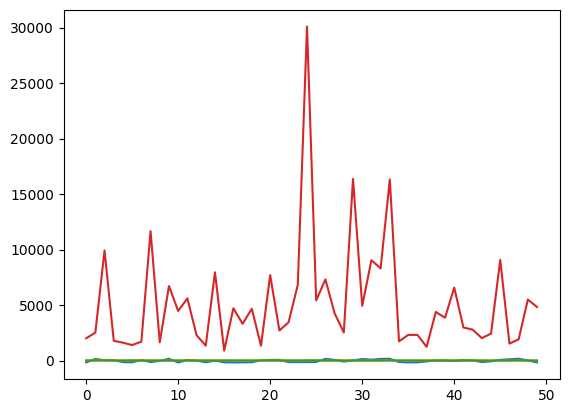

In [78]:
plt.figure()

x = list(range(50))
y1 = train_data[:50]['direction']
y2 = train_data[:50]['distance_haversine']
y3 = train_data[:50]['distance_manhattan']
y4 = google_distance

plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x, y3)
plt.plot(x, y4)

<Axes: >

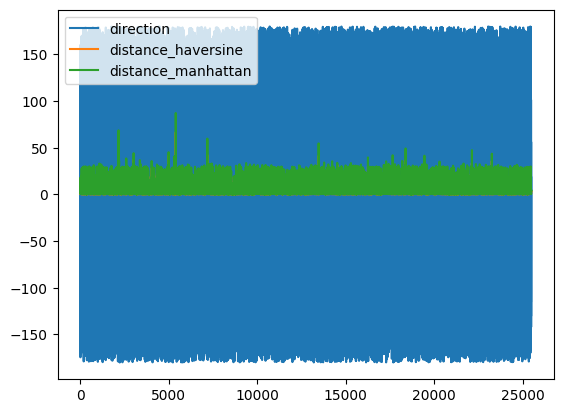

In [77]:
train_data[['direction', 'distance_haversine', 'distance_manhattan']].plot()

In [79]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_week_hour,pickup_dayofyear,pickup_month,pickup_holiday,pickup_near_holiday,direction,distance_haversine,distance_manhattan,center_latitude,center_longitude
0,id1603037,1,2016-06-25 10:36:00,2016-06-25 10:55:00,1,-73.993553,40.747173,-74.006142,40.704384,0,...,130,177,6,0,0,-167.427138,4.874792,5.818438,40.725779,-73.999847
1,id2403238,1,2016-06-23 23:00:00,2016-06-23 23:04:00,1,-73.988068,40.728081,-73.980751,40.721470,0,...,95,175,6,0,0,140.009236,0.959435,1.351629,40.724775,-73.984409
2,id3913101,1,2016-06-25 22:05:00,2016-06-25 22:22:00,2,-74.001411,40.761433,-73.924629,40.864029,0,...,142,177,6,0,0,29.503011,13.111136,17.875008,40.812731,-73.963020
3,id1297351,2,2016-06-24 14:24:00,2016-06-24 14:32:00,1,-74.003288,40.726971,-73.993301,40.739120,0,...,110,176,6,0,0,31.913890,1.591630,2.192557,40.733046,-73.998295
4,id2146569,2,2016-06-23 22:17:00,2016-06-23 22:21:00,1,-73.976799,40.749950,-73.981567,40.745770,0,...,94,175,6,0,0,-139.170150,0.614395,0.866571,40.747860,-73.979183


# UNI-VARIATE ANALYSIS

In [80]:
# Finding number of trips with 0 travelled distance which come out to be 5894.

train_data[(train_data['distance_haversine']==0)].count()

id                     116
vendor_id              116
pickup_datetime        116
dropoff_datetime       116
passenger_count        116
pickup_longitude       116
pickup_latitude        116
dropoff_longitude      116
dropoff_latitude       116
store_and_fwd_flag     116
trip_duration          116
pickup_date            116
pickup_time            116
dropoff_date           116
dropoff_time           116
dropoff_hour           116
dropoff_weekday        116
dropoff_month          116
pickup_weekday         116
pickup_weekofyear      116
pickup_hour            116
pickup_minute          116
pickup_dt              116
pickup_week_hour       116
pickup_dayofyear       116
pickup_month           116
pickup_holiday         116
pickup_near_holiday    116
direction              116
distance_haversine     116
distance_manhattan     116
center_latitude        116
center_longitude       116
dtype: int64

C:\Users\gSegoun\AppData\Local\Temp\ipykernel_30672\1864201238.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(numeric_data[var], color = colors[count], ax = axes[count,1])
C:\Users\gSegoun\AppData\Local\Temp\ipykernel_30672\1864201238.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nu

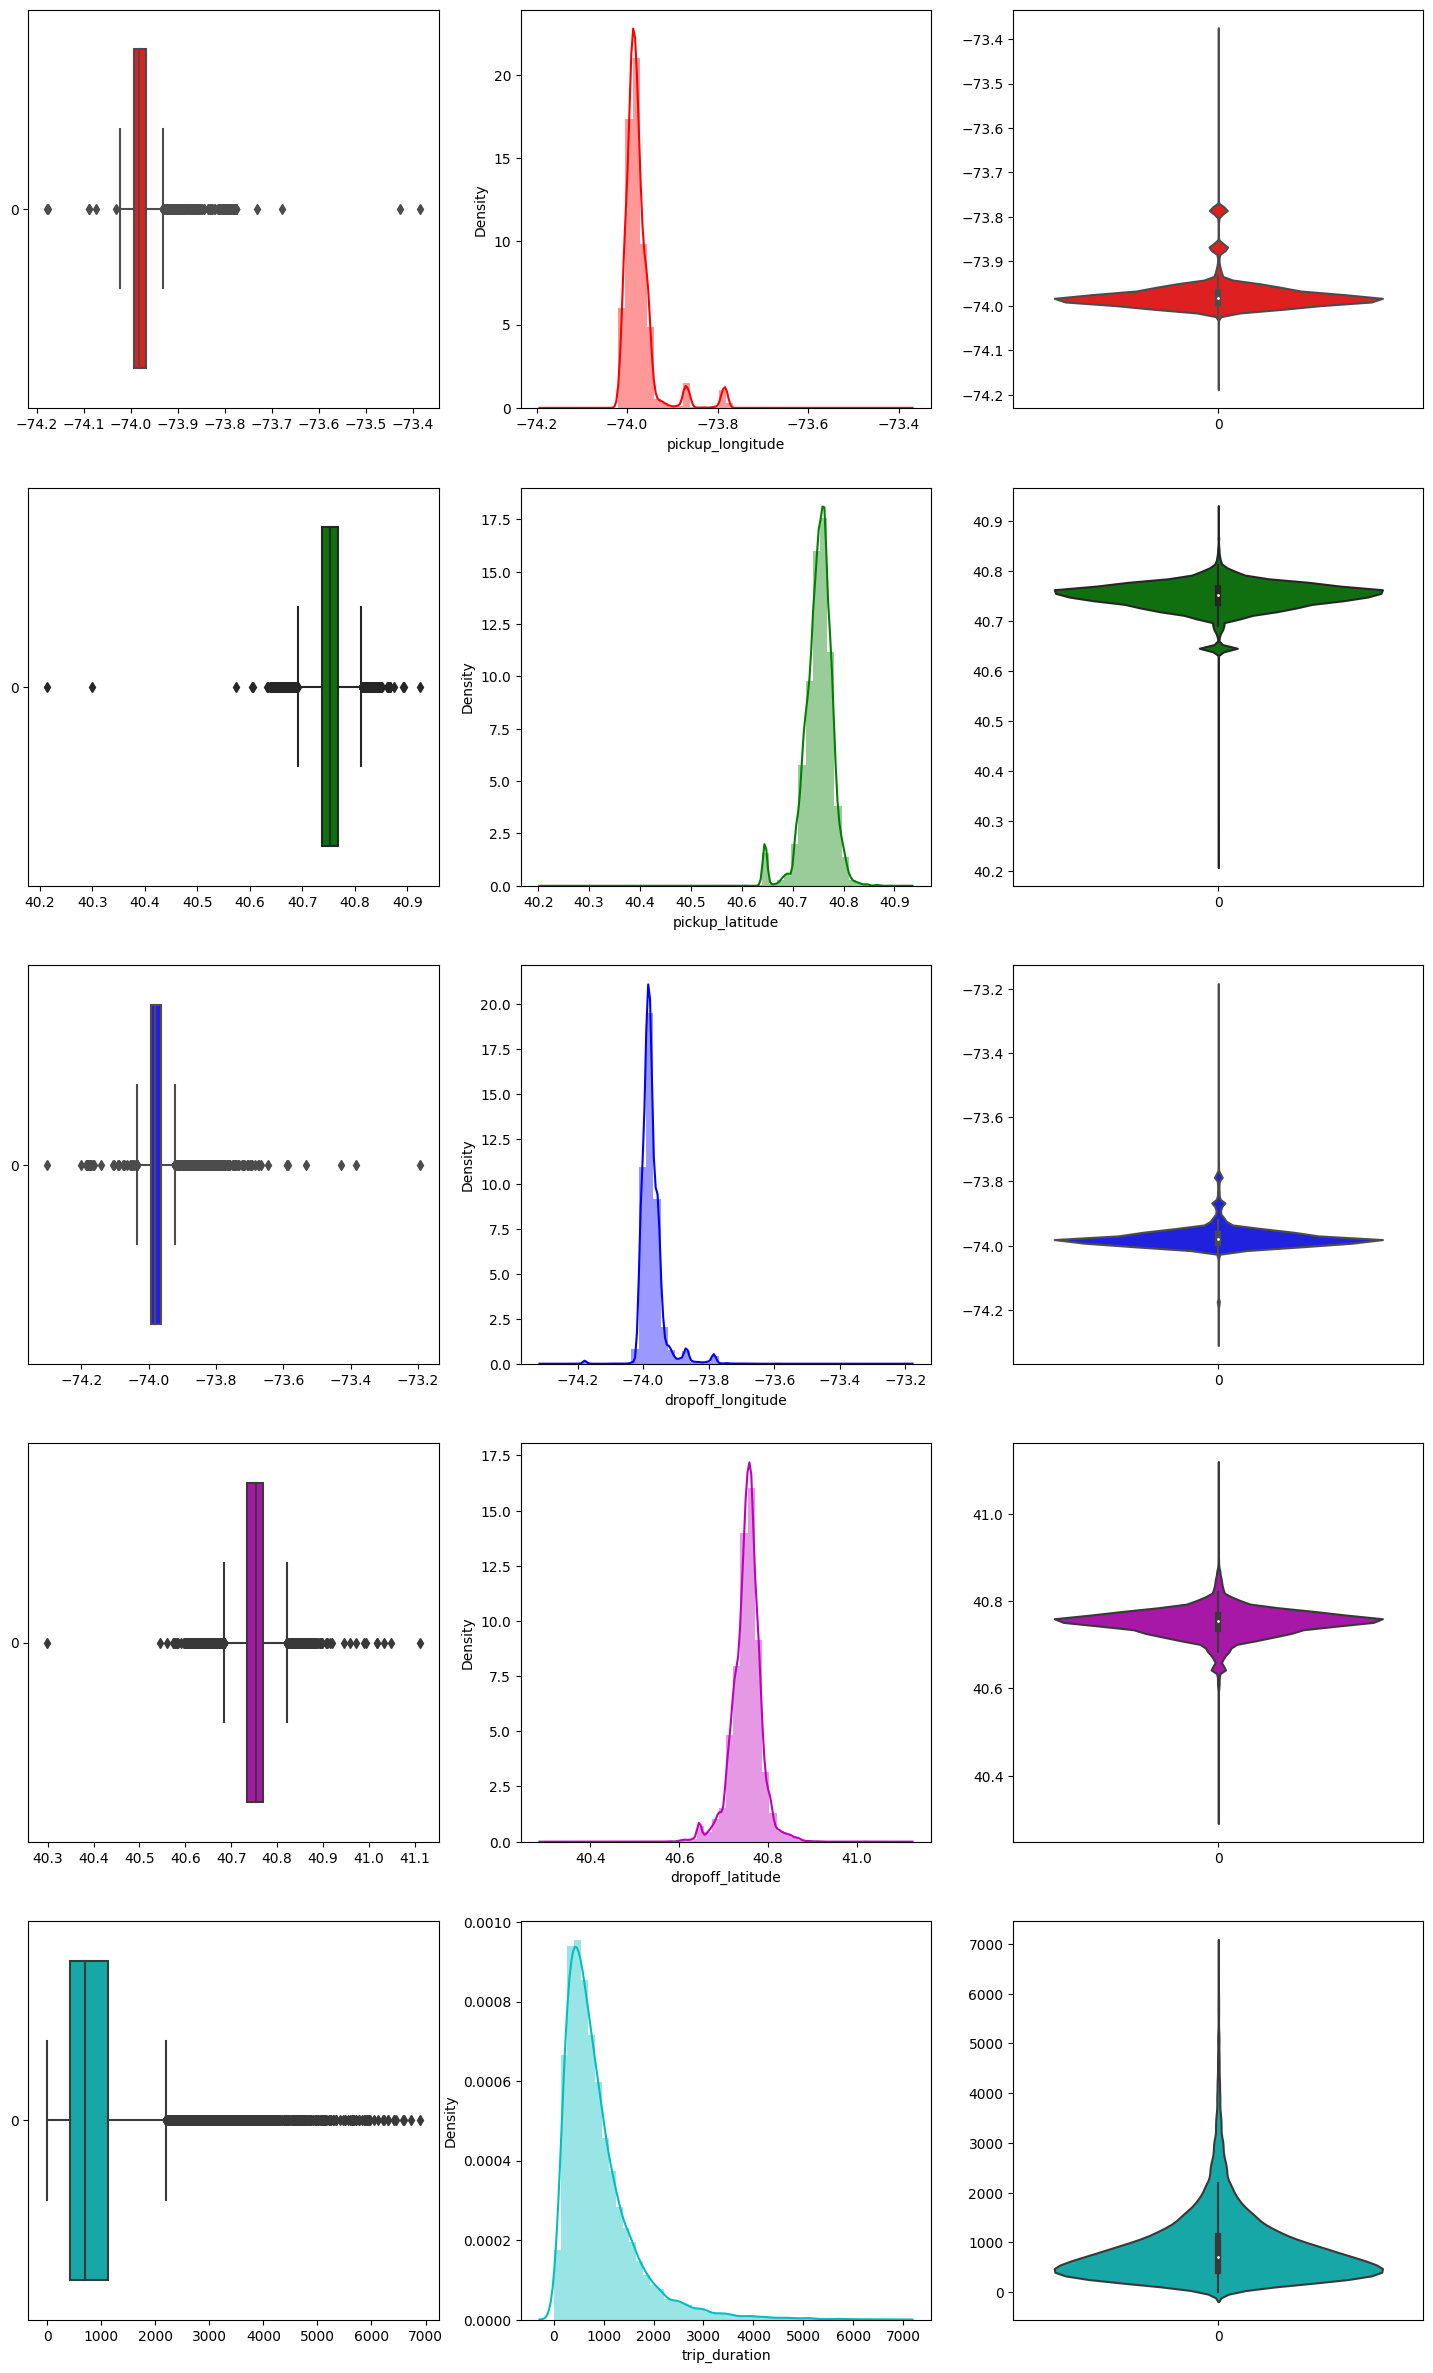

In [81]:
# Numeric Variables: Visualising using Box Plot, Dist Plot, Violin Plot 
# pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_duration

numeric_data = pd.DataFrame(train_data[[
                                        'pickup_longitude',	
                                        'pickup_latitude',	
                                        'dropoff_longitude',	
                                        'dropoff_latitude',	
                                        'trip_duration',	
                                        ]])

f, axes = plt.subplots(5, 3, figsize=(18, 30))
colors = ["r", "g", "b", "m", "c"]

count = 0
for var in numeric_data:
    sns.boxplot(numeric_data[var], orient = "h", color = colors[count], ax = axes[count,0])
    sns.distplot(numeric_data[var], color = colors[count], ax = axes[count,1])
    sns.violinplot(numeric_data[var], color = colors[count], ax = axes[count,2])
    count += 1

<Axes: xlabel='store_and_fwd_flag', ylabel='trip_duration'>

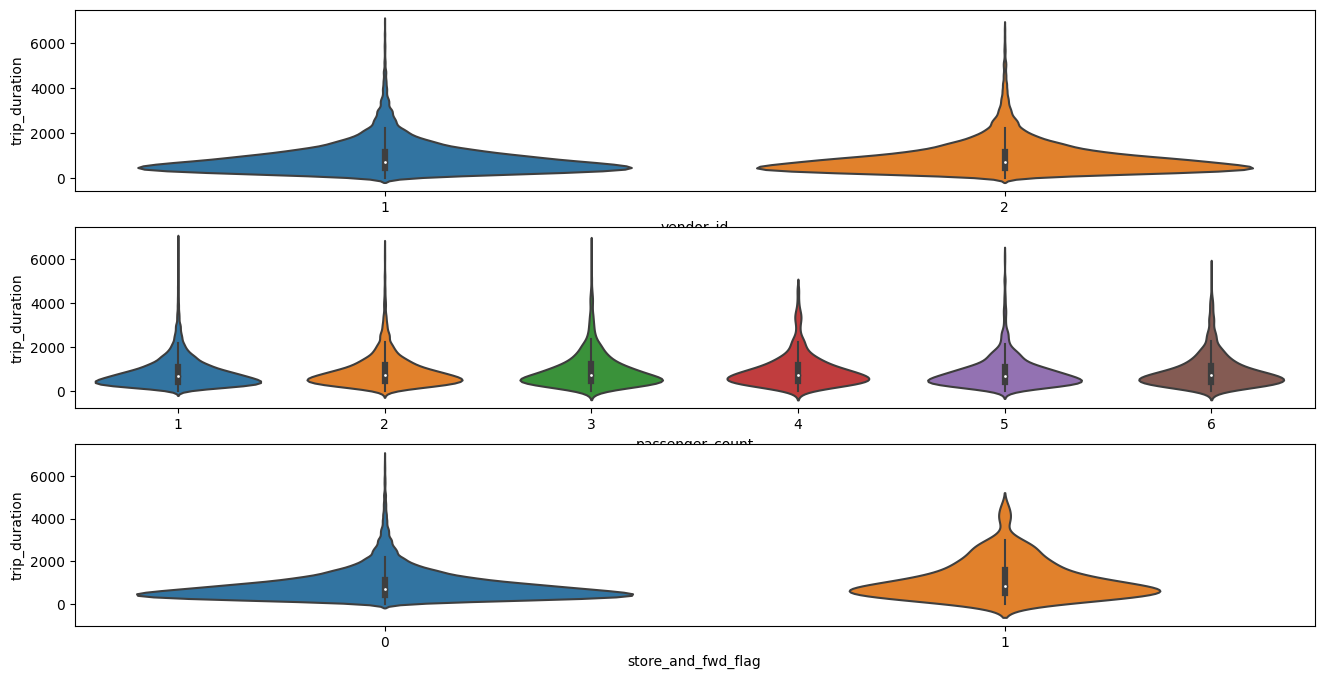

In [82]:
# Categorical Variables: Visualising using Violin Plots
# vendor_id, passenger_count, store_and_fwd_flag

f, axes = plt.subplots(3, 1, figsize=(16,8))

sns.violinplot(x = 'vendor_id', y = 'trip_duration', data = train_data, ax= axes[0])
sns.violinplot(x = 'passenger_count', y = 'trip_duration', data = train_data, ax= axes[1])
sns.violinplot(x = 'store_and_fwd_flag', y = 'trip_duration', data = train_data, ax= axes[2])

C:\Users\gSegoun\AppData\Local\Temp\ipykernel_30672\921408395.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['store_and_fwd_flag'],kde=False)


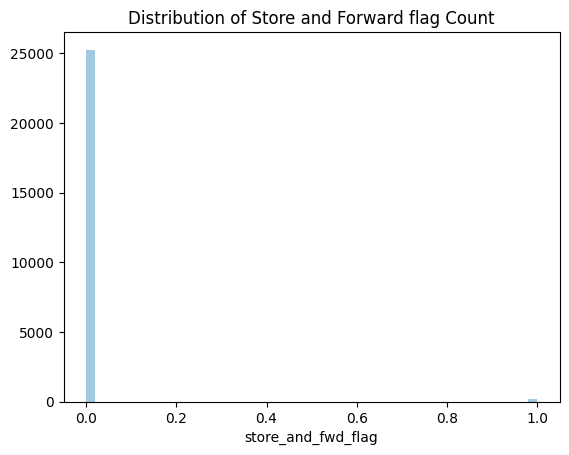

store_and_fwd_flag
0    25270
1      166
Name: count, dtype: int64

In [83]:
# Store and Forward Flag Distribution

sns.distplot(train_data['store_and_fwd_flag'],kde=False)
plt.title('Distribution of Store and Forward flag Count')
plt.show()

train_data['store_and_fwd_flag'].value_counts()

C:\Users\gSegoun\AppData\Local\Temp\ipykernel_30672\993044485.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['passenger_count'],kde=False)


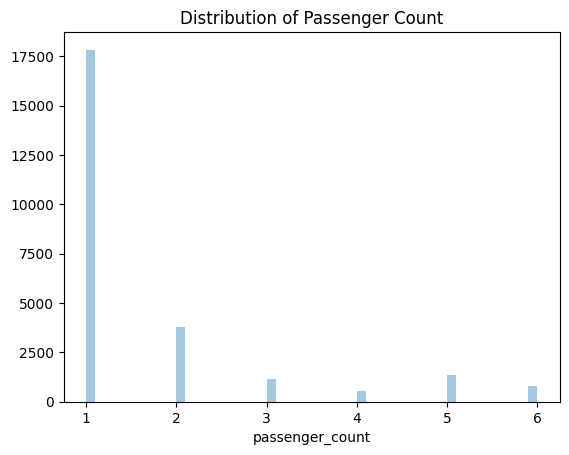

In [84]:
# Passenger Count Distribution

sns.distplot(train_data['passenger_count'],kde=False)
plt.title('Distribution of Passenger Count')
plt.show()

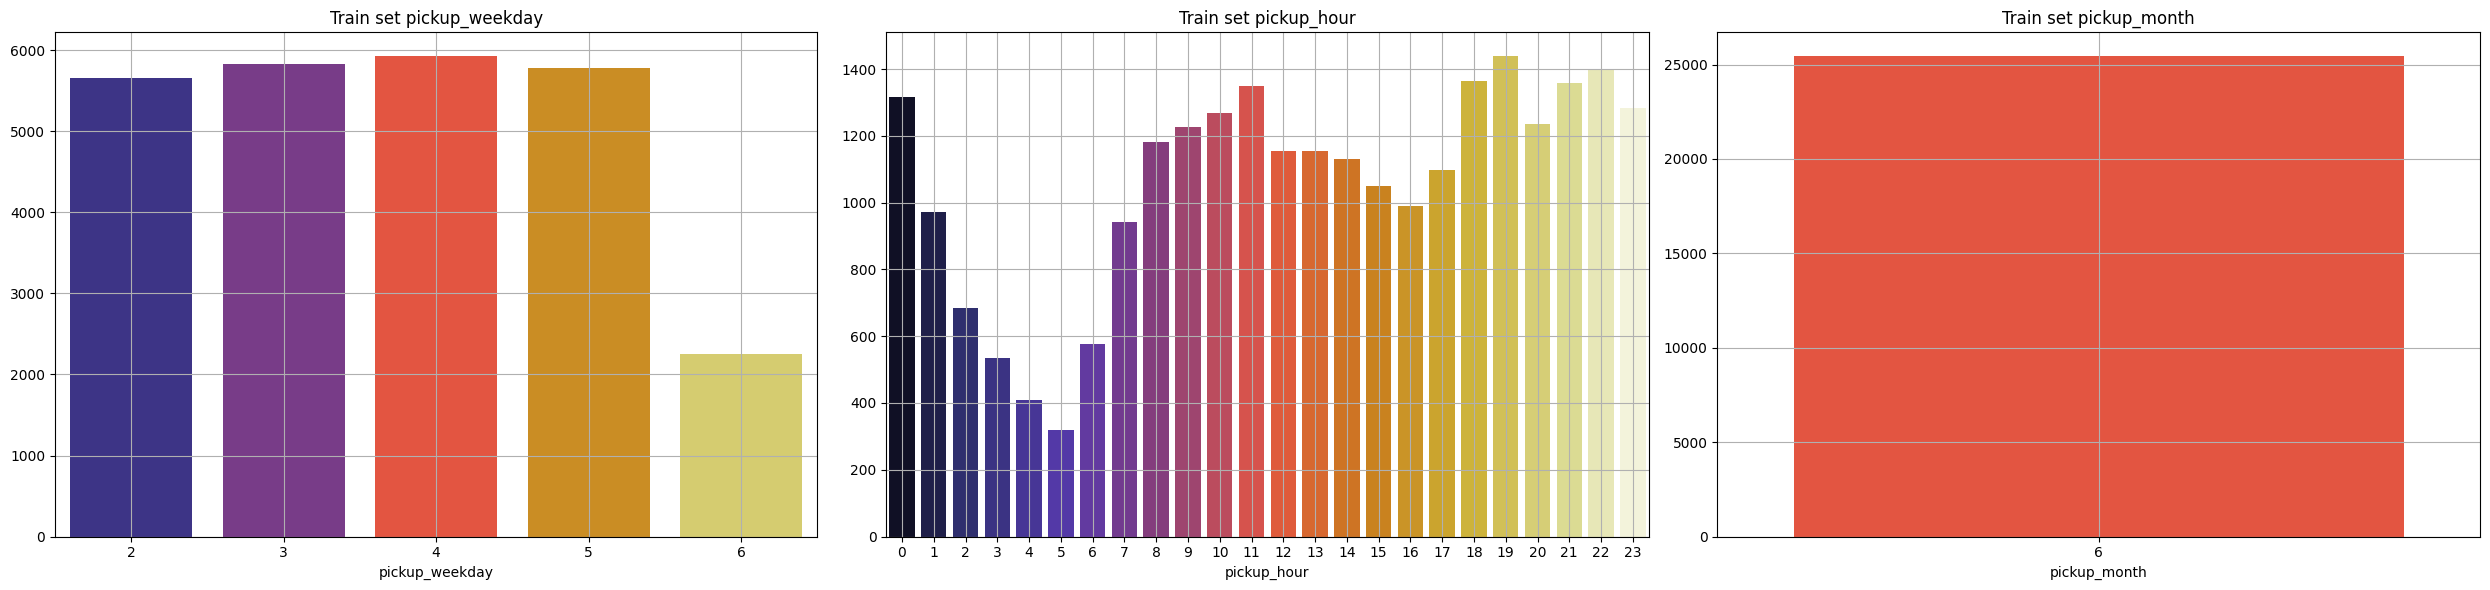

In [85]:
# Count of occurences of each pickup day, pickup hour and pickup month

fig, sub = plt.subplots(1,3,figsize=(25,6))
counter = 0

for feat, subplot in zip(["pickup_weekday","pickup_hour", "pickup_month"], sub.flatten()):
    
    if counter < 3:
        sns.barplot(x=train_data[feat].value_counts().index, y = train_data[feat].value_counts().values, ax= subplot, palette="CMRmap")
        subplot.grid()
        subplot.set_title("Train set {}".format(feat))
    
    counter+=1
    
fig.tight_layout()

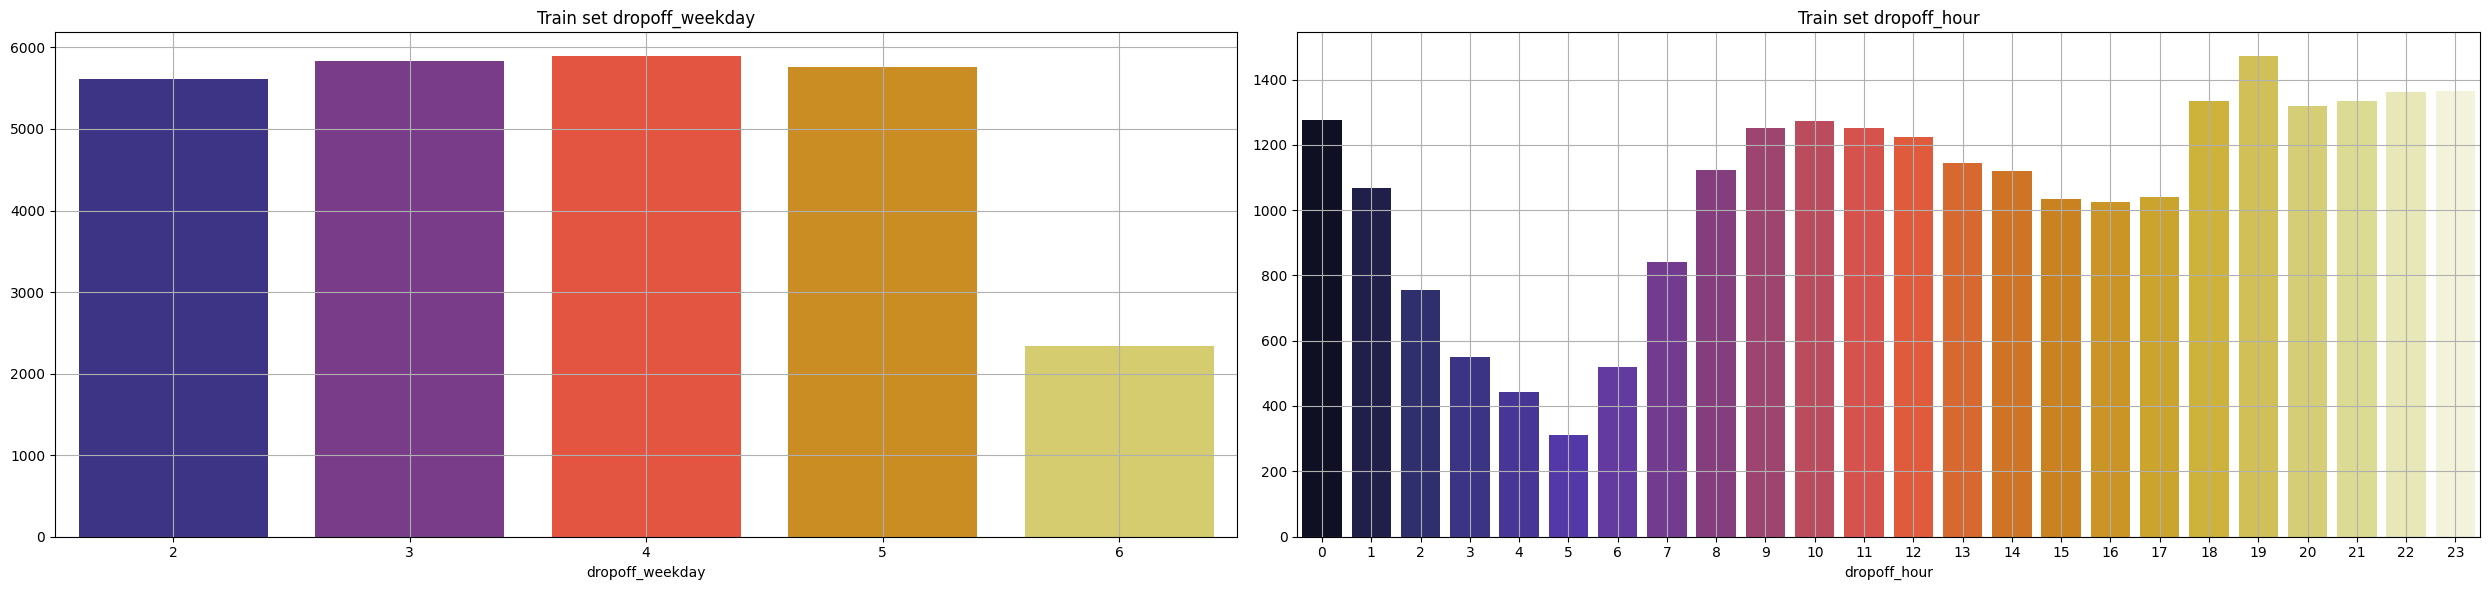

In [86]:
# Count of occurences of each dropoff weekday and dropoff hour 
# dropoff month has been excluded since the pickup month and dropoff month would be in the same month

fig, sub = plt.subplots(1,2,figsize=(25,6))
counter = 0

for feat, subplot in zip(["dropoff_weekday","dropoff_hour"], sub.flatten()):
    
    if counter < 2:
        sns.barplot(x=train_data[feat].value_counts().index, y = train_data[feat].value_counts().values, ax= subplot, palette="CMRmap")
        subplot.grid()
        subplot.set_title("Train set {}".format(feat))
    
    counter+=1
    
fig.tight_layout()

[Text(0.5, 0, 'Trip duration in seconds'), Text(0, 0.5, 'Trip Count')]

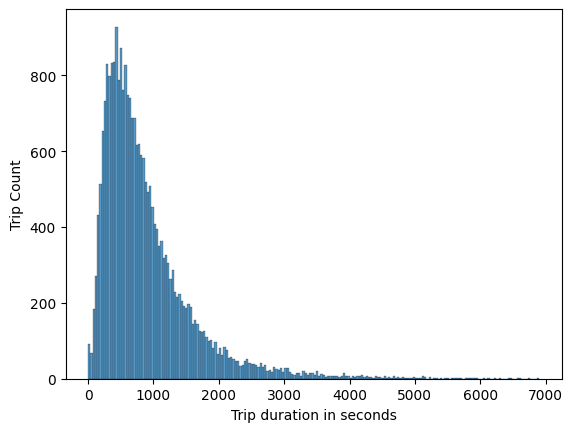

In [87]:
# Histogram to visualise counts for each Trip Duration 

graph = sns.histplot(train_data["trip_duration"], bins = 200)
graph.set(xlabel='Trip duration in seconds', ylabel='Trip Count')

[Text(0.5, 0, 'Trip duration in seconds (Normalised)'),
 Text(0, 0.5, 'Trip Count')]

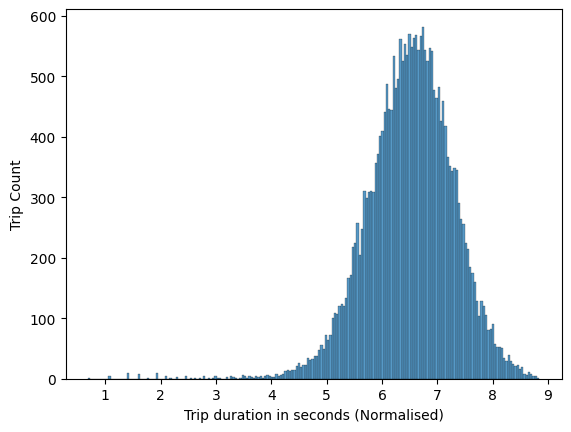

In [88]:
# Histogram to visualise counts for each Trip Duration, with logarithmic normalisation/scaling

train_data['trip_duration_normalised'] = np.log(train_data['trip_duration'].values + 1)
graph = sns.histplot(train_data["trip_duration_normalised"], bins = 200)
graph.set(xlabel='Trip duration in seconds (Normalised)', ylabel='Trip Count')

In [89]:
# Visualise Trips Count by Pick Up date

fig = go.Figure()
pickup_date_count = pd.DataFrame(train_data.groupby('pickup_date').count()[['id']])
pickup_date_count.index.name = 'Pickup Dates'
pickup_date_count.reset_index(inplace=True)


fig.add_trace(go.Scatter(x=pickup_date_count['Pickup Dates'], y=pickup_date_count['id'],
                    mode='lines+markers',
                    name='lines+markers'))

fig.update_xaxes(title_text="Pickup Months")
fig.update_yaxes(title_text="Count of Trips")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'lines+markers',
              'name': 'lines+markers',
              'type': 'scatter',
              'x': array([datetime.date(2016, 6, 22), datetime.date(2016, 6, 23),
                          datetime.date(2016, 6, 24), datetime.date(2016, 6, 25),
                          datetime.date(2016, 6, 26)], dtype=object),
              'y': array([5655, 5826, 5923, 5780, 2252], dtype=int64)}],
    'layout': {'template': '...',
               'xaxis': {'title': {'text': 'Pickup Months'}},
               'yaxis': {'title': {'text': 'Count of Trips'}}}
})

# BI-VARIATE ANALYSIS

ValueError: could not convert string to float: 'id1603037'

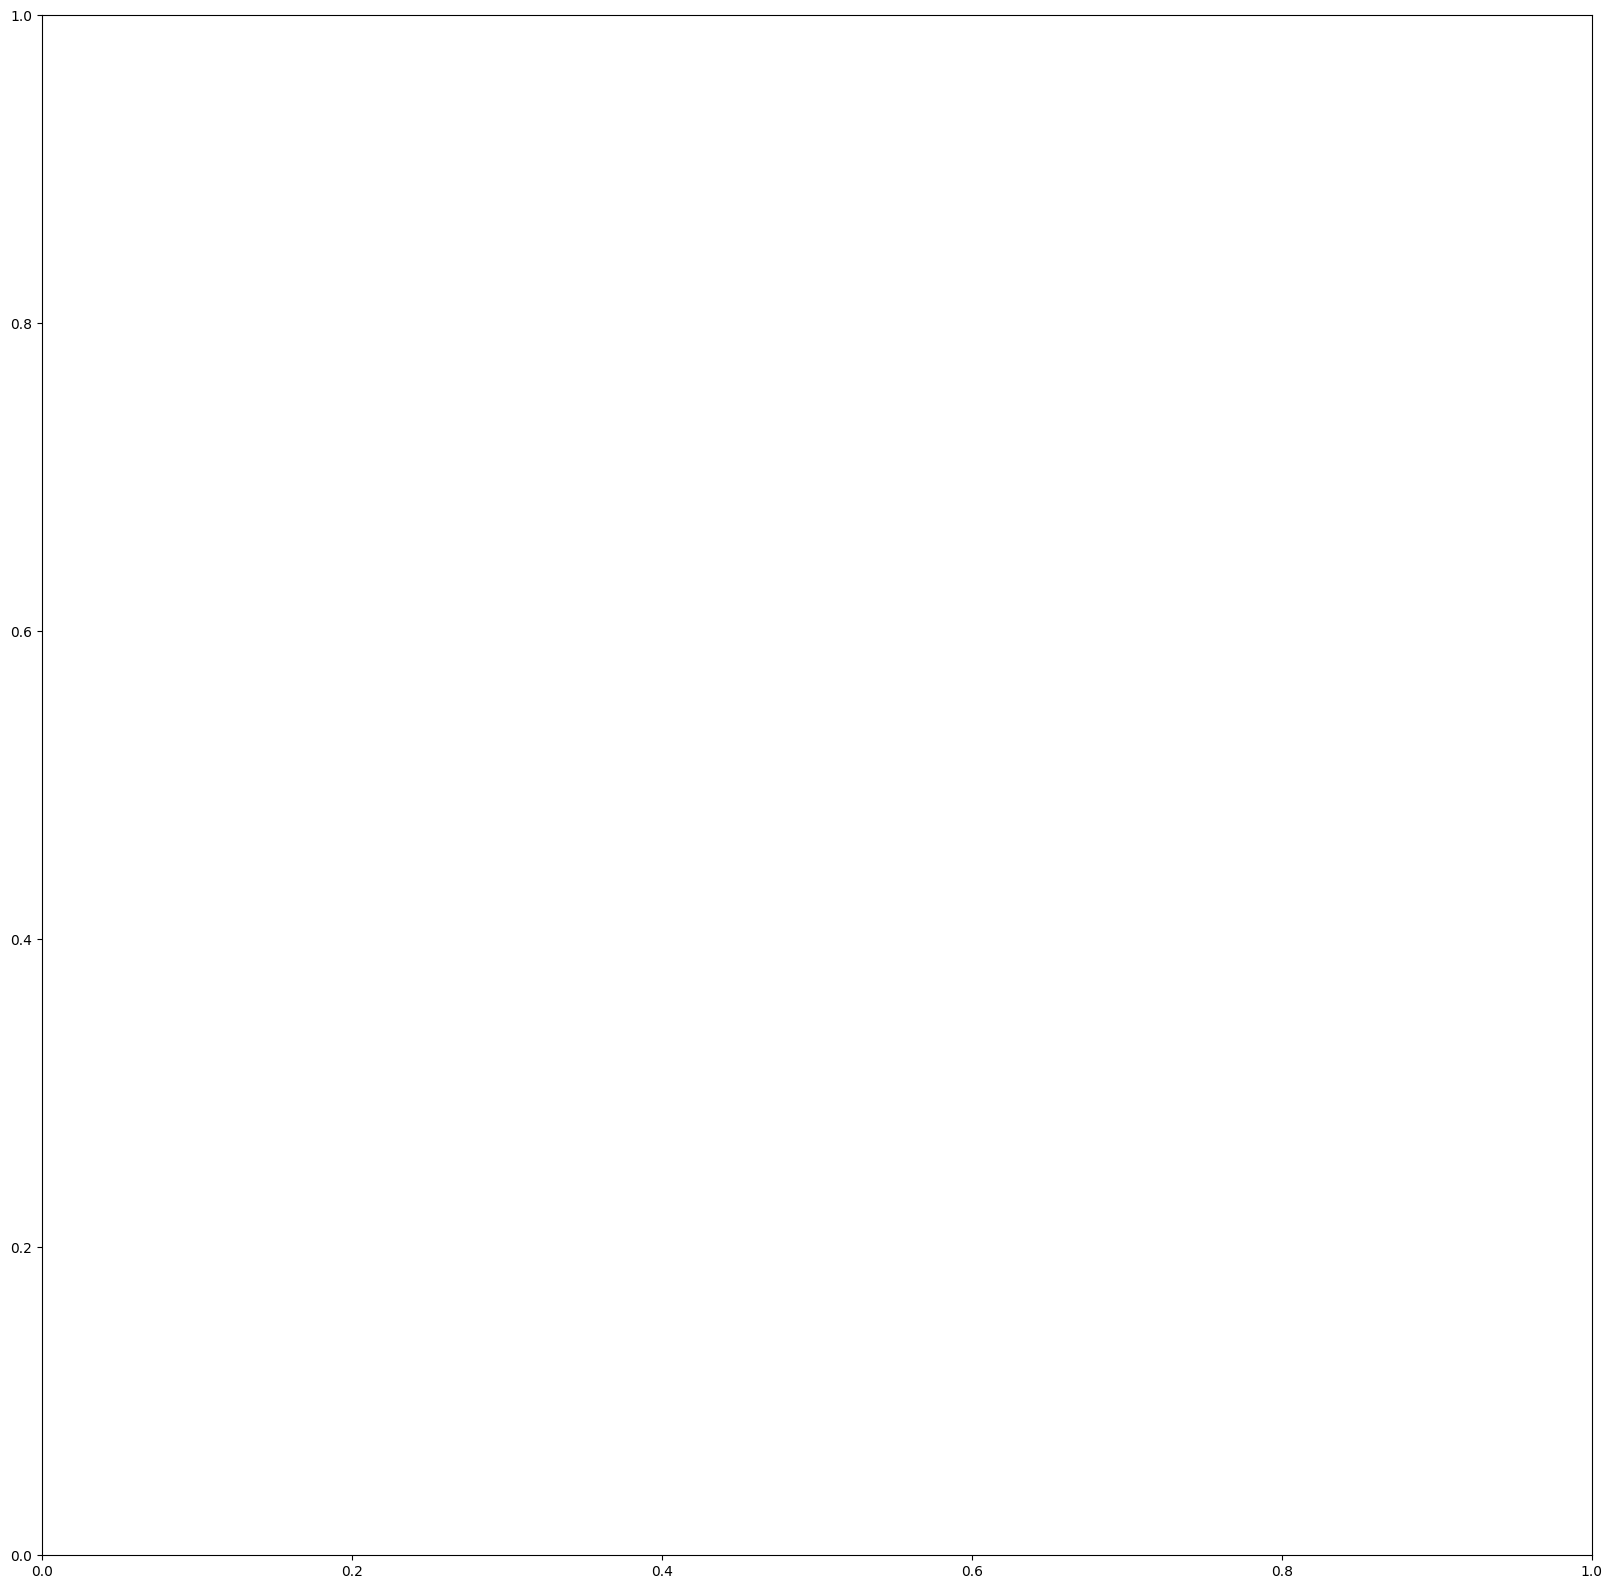

In [90]:
# Heap Map to visualise Feature Correlation

f, axes = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(train_data.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")
f.set_figwidth(30)

TypeError: barplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

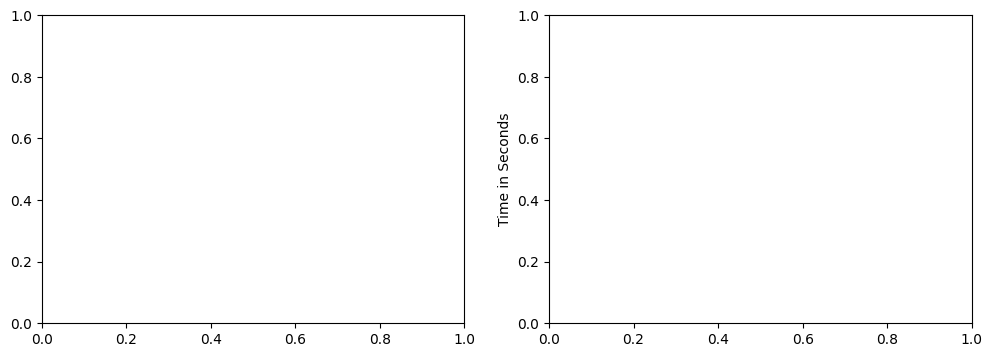

In [91]:
# Average Trip Duration VS Store-and-Forward Flag and Average Trip Duration VS Vendor ID

fig, ax = plt.subplots(ncols=2, figsize=(12,4))

# Average Trip Duration VS Store-and-Forward Flag

store_and_fwd_flag_df = train_data.groupby('store_and_fwd_flag')['trip_duration'].mean()
plt.ylabel('Time in Seconds')
sns.barplot(store_and_fwd_flag_df.index, store_and_fwd_flag_df.values, ax=ax[0])
plt.setp(ax[0], ylabel='Time in Seconds')

# Average Trip Duration VS Vendor ID

vendor_id_df = train_data.groupby('vendor_id')['trip_duration'].mean()
plt.ylabel('Time in Seconds')
sns.barplot(vendor_id_df.index, vendor_id_df.values, ax=ax[1])


TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

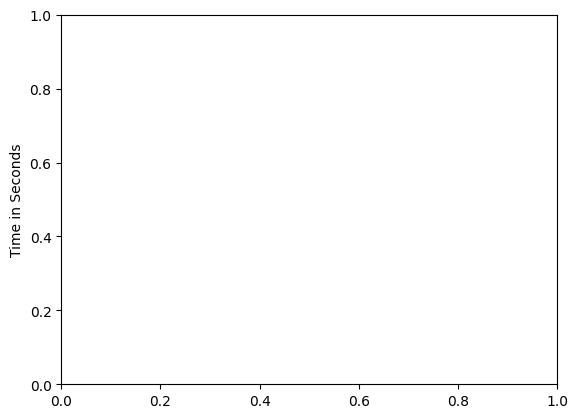

In [92]:
# Passenger Count VS Trip Duration time in seconds

passenger_count_df = train_data.groupby('passenger_count')['trip_duration'].mean()
plt.ylabel('Time in Seconds')
sns.barplot(passenger_count_df.index, passenger_count_df.values)

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

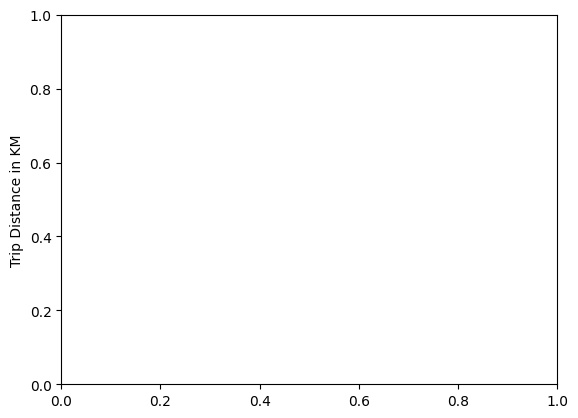

In [93]:
# Passenger Count VS Trip Distance

passenger_count_distance_df = train_data.groupby('passenger_count')['distance_manhattan'].mean()
plt.ylabel('Trip Distance in KM')
sns.barplot(passenger_count_distance_df.index, passenger_count_distance_df.values)

C:\Users\gSegoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



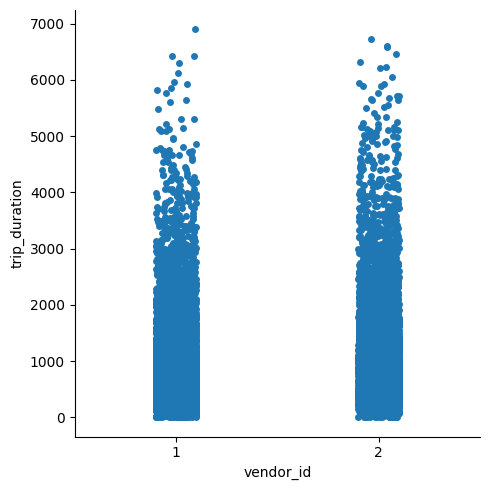

In [94]:
# Relationship b/w Vendor ID and Trip Duration

sns.catplot(x="vendor_id", y="trip_duration",kind="strip",data=train_data)

In [ ]:
# Relationship b/w Trip Duration and Time of Day

ax=sns.catplot(x="pickup_hour", y="trip_duration",kind="bar",data=train_data)
plt.title('Distribution of pickup hours')
plt.show()

In [ ]:
# Relationship b/w Trip Duration and Day of Week

sns.catplot(x="pickup_weekday",y="trip_duration",kind="bar",data=train_data,height=6,aspect=1)
plt.title('The Average Trip Duration per PickUp Day of the Week')

In [ ]:
# Visualise PickUp Locations Density by plotting corresponding Longitudes/Latitudes

fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train_data['pickup_longitude'].values[:625134], train_data['pickup_latitude'].values[:625134],
              color='red', s=1, label='train', alpha=0.5)

ax.title.set_text('Train coordinates')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.xlim(-74.05, -73.76)
plt.ylim(40.60, 40.90)
plt.show()

In [ ]:
# Visualise main Neighbourhoods of New York City 

from sklearn.cluster import KMeans

coordinates_df = pd.DataFrame()
coordinates_df['all_longitude'] = list(train_data.pickup_longitude) + list(train_data.dropoff_longitude)
coordinates_df['all_latitude'] = list(train_data.pickup_latitude) + list(train_data.dropoff_latitude)

kmeans = KMeans(n_clusters=20, random_state=2, n_init = 10).fit(coordinates_df)
coordinates_df['kmeans_label'] = kmeans.labels_

coordinates_df = coordinates_df.sample(200000)
plt.figure(figsize = (10,10))
for label in coordinates_df.kmeans_label.unique():
    plt.plot(coordinates_df.all_longitude[coordinates_df.kmeans_label == label],coordinates_df.all_latitude[coordinates_df.kmeans_label == label],'.', alpha = 0.5, markersize = 0.5)

plt.title('Neighborhoods of New York City')
plt.xlim(-74.05, -73.76)
plt.ylim(40.60, 40.90)
plt.show()

In [ ]:
# Use folium to visualize pickup and dropoff points in New York

import folium
f = folium.Figure(width=1500, height=500)
mapa = folium.Map(location = (40.7679, -73.9822), zoom_start=11).add_to(f)

for index, row in train_data.sample(1000).iterrows():
    folium.Marker([row["pickup_latitude"], row["pickup_longitude"]], icon=folium.Icon(color="blue")).add_to(mapa)
    folium.Marker([row["dropoff_latitude"], row["dropoff_longitude"]], icon=folium.Icon(color="red")).add_to(mapa)


display(mapa)

# FEATURE SELECTION

In [95]:
# PCA - Reducing the dimentionality of the features

from sklearn.decomposition import PCA

coords = np.vstack((train_data[['pickup_latitude', 'pickup_longitude']].values,
                    train_data[['dropoff_latitude', 'dropoff_longitude']].values,
                    test_data[['pickup_latitude', 'pickup_longitude']].values,
                    test_data[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords) # fit the PCA model according to the coordinate values

In [96]:
train_data['pickup_pca0'] = pca.transform(train_data[['pickup_latitude', 'pickup_longitude']])[:, 0] # Derive the PCA feature for Pickup Latitude in Train Dataset
train_data['pickup_pca1'] = pca.transform(train_data[['pickup_latitude', 'pickup_longitude']])[:, 1] # Derive the PCA feature for Pickup Longitude in Train Dataset
train_data['dropoff_pca0'] = pca.transform(train_data[['dropoff_latitude', 'dropoff_longitude']])[:, 0] # Derive the PCA feature for Dropoff Latitude in Train Dataset
train_data['dropoff_pca1'] = pca.transform(train_data[['dropoff_latitude', 'dropoff_longitude']])[:, 1] # Derive the PCA feature for Dropoff Longitude in Train Dataset
test_data['pickup_pca0'] = pca.transform(test_data[['pickup_latitude', 'pickup_longitude']])[:, 0] # Derive the PCA feature for Pickup Latitude in Test Dataset
test_data['pickup_pca1'] = pca.transform(test_data[['pickup_latitude', 'pickup_longitude']])[:, 1] # Derive the PCA feature for Pickup Longitude in Test Dataset
test_data['dropoff_pca0'] = pca.transform(test_data[['dropoff_latitude', 'dropoff_longitude']])[:, 0] # Derive the PCA feature for Dropoff Latitude in Test Dataset
test_data['dropoff_pca1'] = pca.transform(test_data[['dropoff_latitude', 'dropoff_longitude']])[:, 1] # Derive the PCA feature for Dropoff Longitutde in Test Dataset

train_data.loc[:, 'pca_manhattan'] = np.abs(train_data['dropoff_pca1'] - train_data['pickup_pca1']) + np.abs(train_data['dropoff_pca0'] - train_data['pickup_pca0']) # Calculate the Manhattan Distance with PCA Coordinates for Train Dataset
test_data.loc[:, 'pca_manhattan'] = np.abs(test_data['dropoff_pca1'] - test_data['pickup_pca1']) + np.abs(test_data['dropoff_pca0'] - test_data['pickup_pca0']) #Calculate the Manhattan Distance with PCA Coordinated for Test Dataset

C:\Users\gSegoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but PCA was fitted without feature names

C:\Users\gSegoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but PCA was fitted without feature names

C:\Users\gSegoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but PCA was fitted without feature names

C:\Users\gSegoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:457: UserWarning:

X has feature names, but PCA was fitted without feature names

C:\Users\gSegoun\AppData\Local\Packages\Pyth

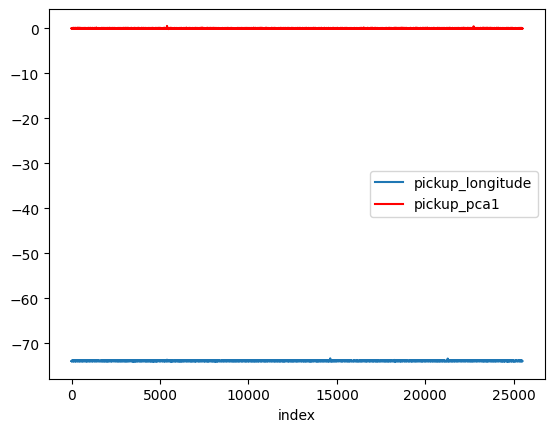

In [97]:
# Visualising a PCA Feature - Pickup Longitude (pickup_pca1) from Train Dataset

ax = plt.gca()

train_data.reset_index().plot(kind='line', x='index', y='pickup_longitude',ax=ax)
train_data.reset_index().plot(kind='line', x='index', y='pickup_pca1', color='red', ax=ax)

plt.show()

# CLUSTERING

In [ ]:

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [ ]:
train_data.loc[:, 'pickup_cluster'] = kmeans.predict(train_data[['pickup_latitude', 'pickup_longitude']])
train_data.loc[:, 'dropoff_cluster'] = kmeans.predict(train_data[['dropoff_latitude', 'dropoff_longitude']])
test_data.loc[:, 'pickup_cluster'] = kmeans.predict(test_data[['pickup_latitude', 'pickup_longitude']])
test_data.loc[:, 'dropoff_cluster'] = kmeans.predict(test_data[['dropoff_latitude', 'dropoff_longitude']])

# MODEL TRAINING

In [98]:
# Listing out the features that should be used for training the XGB Model.

feature_names = list(train_data.columns)
features_not_used = ['id', 'trip_duration_normalised', 'trip_duration', 'dropoff_datetime','dropoff_date','dropoff_hour',
                           'dropoff_month','dropoff_time','dropoff_weekday', 'pickup_date', 'pickup_datetime', 'date','pickup_time','pickup_month']
feature_names = [f for f in train_data.columns if f not in features_not_used]
print(feature_names)
train_data[feature_names].count()

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_weekday', 'pickup_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'pickup_dayofyear', 'pickup_holiday', 'pickup_near_holiday', 'direction', 'distance_haversine', 'distance_manhattan', 'center_latitude', 'center_longitude', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'pca_manhattan']


vendor_id              25436
passenger_count        25436
pickup_longitude       25436
pickup_latitude        25436
dropoff_longitude      25436
dropoff_latitude       25436
store_and_fwd_flag     25436
pickup_weekday         25436
pickup_weekofyear      25436
pickup_hour            25436
pickup_minute          25436
pickup_dt              25436
pickup_week_hour       25436
pickup_dayofyear       25436
pickup_holiday         25436
pickup_near_holiday    25436
direction              25436
distance_haversine     25436
distance_manhattan     25436
center_latitude        25436
center_longitude       25436
pickup_pca0            25436
pickup_pca1            25436
dropoff_pca0           25436
dropoff_pca1           25436
pca_manhattan          25436
dtype: int64

In [107]:
# Performing k-fold splits

X = train_data[feature_names].values
y = np.log(train_data['trip_duration'].values + 1)  
kf = KFold(n_splits=10)
kf.get_n_splits(X)


KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

10
TRAIN: [ 2544  2545  2546 ... 25433 25434 25435] TEST: [   0    1    2 ... 2541 2542 2543]
TRAIN: [    0     1     2 ... 25433 25434 25435] TEST: [2544 2545 2546 ... 5085 5086 5087]
TRAIN: [    0     1     2 ... 25433 25434 25435] TEST: [5088 5089 5090 ... 7629 7630 7631]
TRAIN: [    0     1     2 ... 25433 25434 25435] TEST: [ 7632  7633  7634 ... 10173 10174 10175]
TRAIN: [    0     1     2 ... 25433 25434 25435] TEST: [10176 10177 10178 ... 12717 12718 12719]
TRAIN: [    0     1     2 ... 25433 25434 25435] TEST: [12720 12721 12722 ... 15261 15262 15263]
TRAIN: [    0     1     2 ... 25433 25434 25435] TEST: [15264 15265 15266 ... 17804 17805 17806]
TRAIN: [    0     1     2 ... 25433 25434 25435] TEST: [17807 17808 17809 ... 20347 20348 20349]
TRAIN: [    0     1     2 ... 25433 25434 25435] TEST: [20350 20351 20352 ... 22890 22891 22892]
TRAIN: [    0     1     2 ... 22890 22891 22892] TEST: [22893 22894 22895 ... 25433 25434 25435]


In [100]:
# Setting the XGB Parameters
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(test_data[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_parameters = {'min_child_weight': 10, 'eta': 0.04, 'colsample_bytree': 0.8, 'max_depth': 15,
            'subsample': 0.75, 'lambda': 2, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'gamma' : 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [101]:
# Training the model

model = xgb.train(xgb_parameters, dtrain, 750, watchlist, early_stopping_rounds=250, maximize=False, verbose_eval=15)

[12:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[12:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:5.82392	valid-rmse:5.82686


C:\Users\gSegoun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:617: FutureWarning:

Pass `evals` as keyword args.



[15]	train-rmse:3.18490	valid-rmse:3.18162
[30]	train-rmse:1.76514	valid-rmse:1.76122
[45]	train-rmse:1.01101	valid-rmse:1.01359
[60]	train-rmse:0.61913	valid-rmse:0.64012
[75]	train-rmse:0.41936	valid-rmse:0.46909
[90]	train-rmse:0.31997	valid-rmse:0.39962
[105]	train-rmse:0.26977	valid-rmse:0.37501
[120]	train-rmse:0.24434	valid-rmse:0.36622
[135]	train-rmse:0.23087	valid-rmse:0.36302
[150]	train-rmse:0.22086	valid-rmse:0.36181
[165]	train-rmse:0.21090	valid-rmse:0.36088
[180]	train-rmse:0.20441	valid-rmse:0.36054
[195]	train-rmse:0.19777	valid-rmse:0.35928
[210]	train-rmse:0.19360	valid-rmse:0.35935
[225]	train-rmse:0.18829	valid-rmse:0.35947
[240]	train-rmse:0.18447	valid-rmse:0.35987
[255]	train-rmse:0.18005	valid-rmse:0.35981
[270]	train-rmse:0.17549	valid-rmse:0.35992
[285]	train-rmse:0.17186	valid-rmse:0.35985
[300]	train-rmse:0.16707	valid-rmse:0.35953
[315]	train-rmse:0.16328	valid-rmse:0.35962
[330]	train-rmse:0.15941	valid-rmse:0.35924
[345]	train-rmse:0.15582	valid-rmse:0.

# MODEL PREDICTION 

In [102]:
# Predicting the model on test data

y_test = model.predict(dtest)
y_pred = model.predict(dvalid)

Number of rows for test data and predicted data are same
Valid prediction mean: 6.522
Test prediction mean: 6.520


C:\Users\gSegoun\AppData\Local\Temp\ipykernel_30672\3980101589.py:15: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\gSegoun\AppData\Local\Temp\ipykernel_30672\3980101589.py:16: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




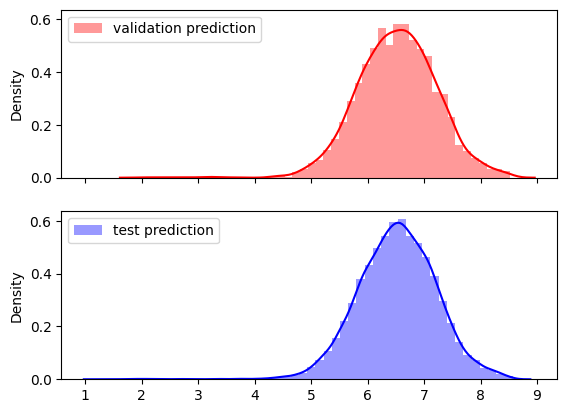

In [103]:
# Check the number of rows of test data to be matching with predicted data.
if test_data.shape[0] == y_test.shape[0]:
  print('Number of rows for test data and predicted data are same')  
else:
  print('Error in Test Data Format')

# Convert predicted dataframe into a csv file for submission
test_data['trip_duration'] = np.exp(y_test) - 1
test_data[['id', 'trip_duration']].to_csv('final_submission.csv', index=False)

# Plot validation and test prediction mean
print('Valid prediction mean: %.3f' % y_pred.mean())
print('Test prediction mean: %.3f' % y_test.mean())
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(y_pred, ax=ax[0], color='red', label='validation prediction')
sns.distplot(y_test, ax=ax[1], color='blue', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()